# Air Quality Optimization
(Extension of Assignment 8)

#### Diondra Stubbs
#### CSC 310 Assignment 10
#### 2022 November 16

## Dataset Description

This dataset contains 9358 instances of hourly averaged responses from an array of 5 metal oxide chemical sensors embedded in an Air Quality Chemical Multisensor Device. The device was located on the field in a significantly polluted area, at road level,within an Italian city. Data were recorded from March 2004 to February 2005 (one year)representing the longest freely available recordings of on field deployed air quality chemical sensor devices responses. More about this dataset: https://archive.ics.uci.edu/ml/datasets/Air+Quality

#### Dataset Features
1. Date (DD/MM/YYYY)
2. Time (HH.MM.SS)
3. CO(GT) - True hourly averaged concentration CO in mg/m^3 (reference analyzer)
4. PT08.S1 (tin oxide) hourly averaged sensor response (nominally CO targeted)  
5. NMHC(GT) - True hourly averaged overall Non Metanic HydroCarbons concentration in microg/m^3 (reference analyzer)
6. C6H6(GT) - True hourly averaged Benzene concentration in microg/m^3 (reference analyzer)
7. PT08.S2 (titania) hourly averaged sensor response (nominally NMHC targeted)
8. NOx(GT) - True hourly averaged NOx concentration in ppb (reference analyzer)
9. PT08.S3 (tungsten oxide) hourly averaged sensor response (nominally NOx targeted)
10. NO2(GT) - True hourly averaged NO2 concentration in microg/m^3 (reference analyzer)
11. PT08.S4 (tungsten oxide) hourly averaged sensor response (nominally NO2 targeted)
12. PT08.S5 (indium oxide) hourly averaged sensor response (nominally O3 targeted)
13. T - Temperature in Â°C
14. RH - Relative Humidity (%)
15. AH - Absolute Humidity

In [289]:
# imports 
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import tree
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import model_selection
from sklearn.metrics import accuracy_score
from sklearn import datasets, linear_model
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

## Loading in Dataset

In [54]:
# loading in data
data_url = 'https://raw.githubusercontent.com/rhodyprog4ds/10-optimization-stubbsdiondra/main/AirQualityUCI.csv?token=GHSAT0AAAAAAB2K2A2A4K3G35P7BB6MI2O4Y3VIAOA'
air_df = pd.read_csv(data_url, sep = ';', decimal = ',')

In [55]:
air_df

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,10/03/2004,18.00.00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,NaN,NaN
1,10/03/2004,19.00.00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,NaN,NaN
2,10/03/2004,20.00.00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,NaN,NaN
3,10/03/2004,21.00.00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,NaN,NaN
4,10/03/2004,22.00.00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9466,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9467,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9468,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9469,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Tidying the Dataset

In [56]:
air_df.shape

(9471, 17)

There should be 9358 rows since there are only 9358 instances. 

In [57]:
# dropping NaN values
air_df.dropna(axis=0, how= 'all', inplace=True)
air_df.dropna(axis=1, inplace=True)

In [215]:
# replacing missing values with avg
air_df.replace(to_replace= -200, value= np.NaN, inplace= True)
air_df.fillna(air_df.mean(), inplace= True)

In [59]:
air_df.shape

(9357, 15)

The target for this dataset in Temperature (T). Since Temperature is a quantity, it is a continuous target. Regression is supervised learning for a continuous target, so I'm going to extend the regression analysis I did in assignment 8.

## Objective

The goal is to optimize the parameters of the regression model I made in my original regression analysis. Before we  perform this task, let's look at the regression analysis again.

In [200]:
# defining the target variable vs other features that contribute
feature_vars = air_df
target_var = air_df['T']
feature_vars = feature_vars.drop('T', axis = 1)

In [201]:
feature_vars.columns

Index(['Date', 'Time', 'CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)',
       'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)',
       'PT08.S5(O3)', 'RH', 'AH'],
      dtype='object')

In [202]:
# dropping irrelevant features
feature_vars = feature_vars.drop('Date', axis = 1)
feature_vars = feature_vars.drop('Time', axis = 1)

## Fitting a Regression Model
Testing it on 25% held out test data and measure the fit with two metrics and one plot

In [203]:
# fitting a linear model with 75% training data
X_train,X_test, y_train,y_test = train_test_split(feature_vars, target_var, train_size=.75)

In [204]:
regr_db = linear_model.LinearRegression()

In [205]:
regr_db.fit(X_train,y_train)

LinearRegression()

In [206]:
#Predict using the linear model.
y_pred = regr_db.predict(X_test)
y_pred.shape

(2340,)

### Computing the R^2 score for linear regression.

The coefficient of determination or R^2 represents the proportion of variance (of y) that has been explained by the independent variables in the model. It provides an indication of goodness of fit and a measure of how well unseen samples are likely to be predicted by the model, through the proportion of explained variance.

[Source](https://scikit-learn.org/stable/modules/model_evaluation.html#r2-score)

In [207]:
regr_db.score(X_test,y_test)

0.9299834598762752

In [208]:
r2_score(y_test, y_pred)

0.9299834598762752

With all the features we get a R^2 score (coefficient of determination) of 0.9299834598762752. This means that ~93% of the data points fall on the regression line and ~93% of the independent/predictor variables in this model explain all the variation in y (Temperature).

### Examinging the Coefficients

In [209]:
regr_db.coef_, regr_db.intercept_

(array([-1.77587947e-01,  1.14214652e-04, -7.55845437e-04, -3.87173799e-01,
         1.11029355e-02,  2.10998689e-03,  5.07886608e-04, -4.36540492e-04,
         5.29931496e-03, -2.77634524e-03, -3.39273660e-01,  1.41653189e+01]),
 8.6320571816804)

In [212]:
feature_vars.columns

Index(['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)',
       'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)',
       'RH', 'AH'],
      dtype='object')

The linear model is:

Temperature = 8.6321 - 0.1776CO(GT) + 0.0001PT08.S1(CO) - 0.0007NMHC(GT) - 0.3871C6H6(GT) + 0.0111PT08.S2(NMHC) +0.0021NOx(GT) + 0.0005PT08.S3(NOx) - 0.0004NO2(GT) + 0.0053PT08.S4(NO2)' - 0.0028PT08.S5(O3) - 0.3393RH + 14.1653AH.

### Examining the Residuals

Residuals are the vertical distance between a data point and the regression line. They are the difference between any data point and the regression line, and are sometimes called “errors.” They  indicate the extent to which a model accounts for the variation in the observed data.

The residual plot is below. The red lines represent the residuals

Text(0, 0.5, 'Temperature')

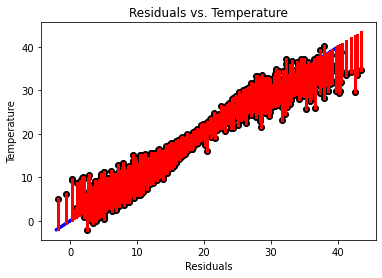

In [213]:
plt.scatter(y_test,y_pred, color='black')
plt.plot(y_pred,y_pred, color='blue', linewidth=3)

# draw vertical lines frome each data point to its predict value
[plt.plot([x,x],[yp,yt], color='red', linewidth=3)
         for x, yp, yt in zip(y_test, y_pred,y_test)]

plt.title('Residuals vs. Temperature')
plt.xlabel('Residuals')
plt.ylabel('Temperature')

The plot shows us that the residuals are spread out around the regression line but pretty close to it. 

### MSE

Mean squared error (MSE) measures the amount of error in a model, looking at the average squared difference between the observed and predicted values. The lower the MSE value there more accurate the model is.

By calculating MSE we are geeting the avg length of all the residuals to cpature the error in this model.

In [214]:
mean_squared_error(y_test,y_pred)

5.184721870138212

The MSE is 5.18. In other words, the average squared difference between the observed and predicted values is 5.18. 

The predictors aren't perfect but it is a good fit, given that ~93% of the independent/predictor variables in this model explain all the variation in y and the amount of error in a model isn't extreme. Therefore, the model fits the data well.

## Cross Validation

Cross validation is a technique for evaluating how well a model performs.

Now we can estimate the model's performance by using CV

Here I am splitting the air quality data, and computing the cross validation score 5 times with different splits each time.

The accuracy of the model is the average of the accuracy of each fold.

In [218]:
air_X = feature_vars
air_y = target_var
cross_val_score(regr_db,air_X,air_y)

array([0.72225193, 0.68631479, 0.84137025, 0.68811545, 0.64798252])

This is the mean of those scores.

In [222]:
np.mean(cross_val_score(regr_db,air_X,air_y))

0.7172069884154374

The accuracy of model with cross validation is 71.72%. The model works pretty fits pretty good on the held out data.

## Grid Search Optimization

To determine the different parameter settings, I'm going to optimize by fitting the model for different parameters and scoring for each and comparing.

Our model was already fit above but I will put it here again.

In [340]:
X_train,X_test, y_train,y_test = train_test_split(feature_vars, target_var,random_state=0)
regr_db = linear_model.LinearRegression()
regr_db.fit(X_train,y_train)
y_pred = regr_db.predict(X_test)

In [341]:
print('Accuracy Score : ' + str(r2_score(y_test, y_pred)))

Accuracy Score : 0.9302332577232275


The accuracy is ~93% 

In [342]:
# Get default hyperparameters
regr_db.get_params()

{'copy_X': True,
 'fit_intercept': True,
 'n_jobs': None,
 'normalize': False,
 'positive': False}

In [343]:
# number of features in X_train
len(X_train.columns)

12

In [344]:
hyper_params = [{'n_features_to_select': list(range(1, 13))}]

In [345]:
from sklearn.feature_selection import RFE

In [346]:
rfe = RFE(regr_db) 

In [347]:
reg_opt = GridSearchCV(estimator = rfe, param_grid = hyper_params) 

Here I am optimizing the model with default paramters.

In [348]:
reg_opt.fit(air_X, air_y)  

GridSearchCV(estimator=RFE(estimator=LinearRegression()),
             param_grid=[{'n_features_to_select': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11, 12]}])

In [349]:
reg_opt.cv_results_

{'mean_fit_time': array([0.01780267, 0.01680417, 0.01840439, 0.0154037 , 0.01600413,
        0.01360326, 0.01280322, 0.01260266, 0.01120272, 0.0100039 ,
        0.00719008, 0.00540209]),
 'std_fit_time': array([0.00146802, 0.00074812, 0.00048996, 0.00080022, 0.00063271,
        0.00135656, 0.00098052, 0.00048996, 0.00074874, 0.00063173,
        0.00073559, 0.00048949]),
 'mean_score_time': array([0.00240102, 0.00220022, 0.00280037, 0.00200024, 0.00220037,
        0.00200033, 0.00199957, 0.00220032, 0.00220027, 0.00239954,
        0.00259972, 0.00239935]),
 'std_score_time': array([4.89377643e-04, 4.00018763e-04, 4.00376444e-04, 2.43140197e-07,
        3.99232121e-04, 5.84003864e-07, 1.08106461e-06, 4.00090313e-04,
        4.00114074e-04, 4.90680093e-04, 4.89883430e-04, 4.89375878e-04]),
 'param_n_features_to_select': masked_array(data=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, Fa

In [350]:
pd.DataFrame(reg_opt.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_features_to_select,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.017803,0.001468,0.002401,4.893776e-04,1,{'n_features_to_select': 1},-0.271216,-1.506428,-0.381849,-0.548622,-0.075372,-0.556697,0.499159,12
1,0.016804,0.000748,0.002200,4.000188e-04,2,{'n_features_to_select': 2},0.899770,0.647617,0.810142,0.697367,0.577402,0.726460,0.115169,2
2,0.018404,0.000490,0.002800,4.003764e-04,3,{'n_features_to_select': 3},0.900762,0.651087,0.807456,0.702469,0.579867,0.728328,0.113728,1
3,0.015404,0.000800,0.002000,2.431402e-07,4,{'n_features_to_select': 4},0.823308,0.651026,0.792147,0.703416,0.582232,0.710426,0.088805,11
4,0.016004,0.000633,0.002200,3.992321e-04,5,{'n_features_to_select': 5},0.833103,0.674591,0.799992,0.654383,0.597486,0.711911,0.089712,10
5,0.013603,0.001357,0.002000,5.840039e-07,6,{'n_features_to_select': 6},0.833019,0.678443,0.841770,0.665522,0.594175,0.722586,0.098076,4
6,0.012803,0.000981,0.002000,1.081065e-06,7,{'n_features_to_select': 7},0.825987,0.677698,0.842892,0.656279,0.604451,0.721461,0.095421,6
7,0.012603,0.000490,0.002200,4.000903e-04,8,{'n_features_to_select': 8},0.744635,0.674116,0.847270,0.670869,0.644049,0.716188,0.073511,9
8,0.011203,0.000749,0.002200,4.001141e-04,9,{'n_features_to_select': 9},0.734315,0.687328,0.847400,0.688901,0.650653,0.721720,0.068212,5
9,0.010004,0.000632,0.002400,4.906801e-04,10,{'n_features_to_select': 10},0.748194,0.686605,0.843569,0.688440,0.650949,0.723551,0.067647,3


Now I'm using it to get predicitions and get the score.

In [351]:
y_pred = reg_opt.predict(X_test)

In [352]:
reg_opt.fit(X_train,y_train)

GridSearchCV(estimator=RFE(estimator=LinearRegression()),
             param_grid=[{'n_features_to_select': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11, 12]}])

In [353]:
reg_opt.score(X_test,y_test)

0.9301609709121904

The accuracy is still ~92%.

And the overall results.

In [354]:
reg_5cv_df = pd.DataFrame(reg_opt.cv_results_)
reg_5cv_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_features_to_select,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.017001,0.001416,0.002401,0.000490,1,{'n_features_to_select': 1},0.391404,0.438626,0.447131,0.463111,0.404658,0.428986,0.026799,12
1,0.016404,0.001200,0.002001,0.000001,2,{'n_features_to_select': 2},0.917966,0.918479,0.920180,0.917696,0.921229,0.919110,0.001367,11
2,0.015203,0.000748,0.002401,0.000490,3,{'n_features_to_select': 3},0.918156,0.918750,0.920690,0.918022,0.921659,0.919455,0.001458,10
3,0.013003,0.001096,0.002201,0.000400,4,{'n_features_to_select': 4},0.918310,0.919157,0.921482,0.917576,0.922241,0.919753,0.001809,9
4,0.014007,0.001898,0.002400,0.000489,5,{'n_features_to_select': 5},0.918998,0.921580,0.922823,0.925589,0.928851,0.923568,0.003388,8


## Plotting  Cross Validation results

Looking at the performance.

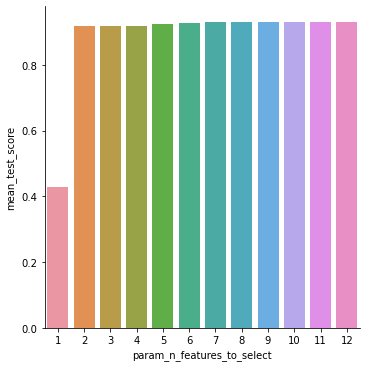

In [355]:
sns.catplot(data=reg_5cv_df, x='param_n_features_to_select',y='mean_test_score', kind='bar',)

In terms of performance, when the number of features selected is one, it sticks out, The mean test score is much smaller than when 2,3,4,5,6,7,8,9,10,11 or 12 features are selected.

The more data it has to learn from, the better the test score.

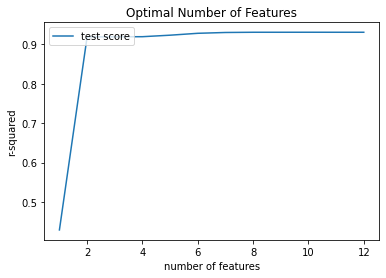

In [395]:
plt.plot(reg_5cv_df["param_n_features_to_select"], reg_5cv_df["mean_test_score"])
plt.xlabel('number of features')
plt.ylabel('r-squared')
plt.title("Optimal Number of Features")
plt.legend(['test score', 'train score'], loc='upper left')

The R^2 increases as you increase the number of features but it increases significantly when more than one feature is used.

## Best performing model parameters

In [357]:
reg_opt.best_params_

{'n_features_to_select': 10}

In [366]:
n_features_optimal = 10

In [367]:
rfe = RFE(regr_db, n_features_to_select=n_features_optimal)  
reg_opt10 = rfe.fit(X_train, y_train)

In [368]:
y_pred = regr_db.predict(X_test)

In [369]:
reg_opt10.score(X_test,y_test)

0.9298573440696615

The score is still ~93%. Using the best performing model parameters gives us the same results as default.

In [373]:
cross_val_score(rfe,air_X,air_y)

array([0.74819448, 0.6866052 , 0.84356926, 0.68843958, 0.65094882])

In [376]:
np.mean(cross_val_score(rfe,air_X,air_y))

0.7235514697054415

The accuracy of model with cross validation is a little better are 72.36%. The model works pretty fits pretty good on the held out data.

### Scoring the best fit model on a held out test set.

I'm going to hold out 50% of the data.

In [370]:
X_train,X_test, y_train,y_test = train_test_split(feature_vars, target_var,random_state=0, train_size=0.5)

In [371]:
rfe = RFE(regr_db, n_features_to_select=n_features_optimal)  
reg_opt8 = rfe.fit(X_train, y_train)
y_pred = regr_db.predict(X_test)

In [372]:
reg_opt8.score(X_test,y_test)

0.9298573440696615

The score is still ~93% holding out 50% of the data for the test set.

## Interpretting the cross validation results

The results of each cross validation indicate that the default and best fit models perform well. The accuracy for each is ~93% indicating that the model performs well.

The cross validation score is a little better when using best fit model yet still very close to that of the default.

## Varying the cross validation parameters

I'm going to do this by varying the number of folds. The default is 5, I'm going to try 10 and 15.

In [377]:
kf = KFold(n_splits = 10)

In [378]:
new_opt = GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params,
                        cv = kf)      

In [379]:
new_opt.fit(air_X, air_y)  

GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=False),
             estimator=RFE(estimator=LinearRegression(),
                           n_features_to_select=10),
             param_grid=[{'n_features_to_select': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11, 12]}])

In [393]:
new_results = pd.DataFrame(new_opt.cv_results_)
new_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_features_to_select,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.021505,0.002907,0.002901,0.001136,1,{'n_features_to_select': 1},-0.205499,-0.778025,-0.875772,-1.978262,-0.987910,-1.201317,-0.543006,-0.377017,-0.637041,0.229515,-0.735433,0.568687,12
1,0.019504,0.001204,0.002400,0.000490,2,{'n_features_to_select': 2},0.913638,0.862657,0.826783,0.503889,0.751812,0.834269,0.745703,0.726465,0.311278,0.799229,0.727572,0.174207,8
2,0.018404,0.001114,0.002501,0.000500,3,{'n_features_to_select': 3},0.910685,0.862617,0.825658,0.507740,0.753864,0.814844,0.750838,0.724400,0.317838,0.800368,0.726885,0.170807,9
3,0.016504,0.000807,0.002201,0.000400,4,{'n_features_to_select': 4},0.847802,0.866539,0.827297,0.512734,0.754690,0.765501,0.747940,0.730623,0.322808,0.801790,0.717773,0.161508,11
4,0.016706,0.001011,0.002799,0.000600,5,{'n_features_to_select': 5},0.847916,0.887146,0.834593,0.536930,0.753886,0.786694,0.707967,0.735860,0.350500,0.810526,0.725202,0.155369,10
5,0.015404,0.001562,0.002301,0.000458,6,{'n_features_to_select': 6},0.849784,0.889942,0.836819,0.541958,0.748424,0.875445,0.712499,0.765030,0.486487,0.839191,0.754558,0.132256,5
6,0.013506,0.001358,0.002297,0.000455,7,{'n_features_to_select': 7},0.847367,0.896469,0.836835,0.541382,0.757961,0.875505,0.747955,0.763542,0.482032,0.825864,0.757491,0.132287,3
7,0.012002,0.001001,0.002401,0.000490,8,{'n_features_to_select': 8},0.848131,0.897887,0.837256,0.537335,0.762211,0.876776,0.757500,0.757457,0.494519,0.826169,0.759524,0.130705,2
8,0.010404,0.001199,0.002600,0.000490,9,{'n_features_to_select': 9},0.857424,0.898097,0.848809,0.554101,0.762118,0.877842,0.753732,0.746730,0.513061,0.825959,0.763787,0.125752,1
9,0.010002,0.000633,0.002601,0.000664,10,{'n_features_to_select': 10},0.813182,0.897131,0.848878,0.552189,0.761805,0.864897,0.753137,0.734152,0.513842,0.815161,0.755437,0.121601,4


In [386]:
cross_val_score(regr_db,air_X,air_y,cv=10)

array([0.79171219, 0.8962544 , 0.84768419, 0.55208014, 0.76222114,
       0.85917805, 0.74682295, 0.73080126, 0.51302359, 0.81276681])

In [387]:
np.mean(cross_val_score(regr_db,air_X,air_y,cv=10))

0.7512544706573401

In [388]:
cross_val_score(regr_db,air_X,air_y,cv=15)

array([0.83724219, 0.92811136, 0.87968944, 0.88145665, 0.61343503,
       0.58410367, 0.77011478, 0.84109058, 0.84929207, 0.88263037,
       0.59515709, 0.69155367, 0.60793537, 0.12874098, 0.77838828])

In [389]:
np.mean(cross_val_score(regr_db,air_X,air_y,cv=15))

0.724596102505353

The original model's accuracy was 71.72% at 5 folds. At 10 folds, the accuracy of the model is 75.12% and 72.46% at 15 folds. 

In [390]:
np.mean(cross_val_score(regr_db,air_X,air_y,cv=20))

0.7393767601557284

In [391]:
np.mean(cross_val_score(regr_db,air_X,air_y,cv=25))

0.7050924193450416

In [392]:
np.mean(cross_val_score(regr_db,air_X,air_y,cv=7))

0.7600860019442287

At 20 folds, the accuracy of the model is 73.93% and 70.51% at 25 folds.

It seems like the model's performance changes as you increase the number of folds. It increases between 5 and 10 folds, decreases between 10 and 15, increases between 15 and 20 and decreases between 20 and 25 folds. 

A plot would like peaks and troughs.

My initial though was that the model would perform better as you increase the number of folds but my conclusion has changed.